In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Machine Learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import dependancies for overfitting
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
# Read data from csv
insider_df = pd.read_csv("Resources/Insider_Trading_Cleaned.csv")
insider_df.head()

,Company,Filing Date,Trade Date,Ticker,Insider Name,Title,Transaction Type,Price,Quantity,Owned,Change of Amount Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close
0,0 Relic Inc.,03/09/2020 17:31,01/09/2020,0R,Cirne Lewis,CEO 10%,S - Sale,62.74,-35500,6202967,-1%,-2227184,61.730000,60.320000,61.529999,62.799999
1,0 Relic Inc.,02/10/2020 17:52,01/10/2020,0R,Cirne Lewis,CEO 10%,S - Sale,57.48,-34500,6168467,-1%,-1982897,56.029999,56.310001,57.150002,57.349998
2,0 Relic Inc.,04/11/2020 17:03,02/11/2020,0R,Cirne Lewis,CEO 10%,S - Sale,58.92,-35500,6132976,-1%,-2091741,63.330002,63.150002,60.959999,58.919998
3,0 Relic Inc.,10/11/2020 19:13,10/11/2020,0R,Henshall David J,Dir,P - Purchase,54.74,4750,4750,0,260009,55.450001,53.730000,55.450001,53.730000
4,0 Relic Inc.,17/11/2020 18:13,16/11/2020,0R,Sachleben Mark,CFO,S - Sale+OE,56.00,-2351,371740,-1%,-131661,55.150002,56.450001,56.029999,54.790001


In [3]:
insider_df = insider_df.drop_duplicates()

In [4]:
insider_df.describe()

,Price,Quantity,Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close
count,35441.000000,3.544100e+04,3.544100e+04,3.544100e+04,35441.000000,35441.000000,35441.000000,35441.000000
mean,148.597593,-7.621062e+04,5.869680e+06,-5.173418e+06,123.547910,123.548506,129.065983,129.311043
std,514.423546,1.747556e+06,6.638473e+07,5.402872e+07,179.681994,179.878579,179.103944,179.388862
min,0.000000,-1.328413e+08,0.000000e+00,-2.147484e+09,0.000000,0.000000,0.000000,0.000000
25%,35.000000,-1.800000e+04,1.765200e+04,-1.574949e+06,29.260000,29.200001,35.180000,35.270000
50%,79.630000,-5.000000e+03,6.162800e+04,-4.137000e+05,75.089996,75.260002,79.489998,79.820000
75%,155.000000,-1.114000e+03,2.606140e+05,-8.278300e+04,147.690002,147.309998,152.580002,152.850006
max,81700.600000,6.342412e+07,2.147484e+09,2.147484e+09,2664.810059,2623.949951,2573.479980,2635.159912


In [5]:
insider_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35441 entries, 0 to 37708
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company                 35441 non-null  object 
 1   Filing Date             35441 non-null  object 
 2   Trade Date              35441 non-null  object 
 3   Ticker                  35441 non-null  object 
 4   Insider Name            35441 non-null  object 
 5   Title                   35441 non-null  object 
 6   Transaction Type        35441 non-null  object 
 7   Price                   35441 non-null  float64
 8   Quantity                35441 non-null  int64  
 9   Owned                   35441 non-null  int64  
 10  Change of Amount Owned  35441 non-null  object 
 11  Value                   35441 non-null  int64  
 12  Date Filed Open         35441 non-null  float64
 13  Date Filed Close        35441 non-null  float64
 14  Date Traded Open        35441 non-null

In [6]:
insider_df.drop("Change of Amount Owned", axis=1, inplace=True)

In [7]:
# insider_df["Change of Amount Owned"] = insider_df["Quantity"]/(insider_df["Owned"]- insider_df["Quantity"])
insider_df["Change of Amount Owned"] = np.where((insider_df["Quantity"]-insider_df["Owned"]) != 0, insider_df["Quantity"]/(insider_df["Owned"]- insider_df["Quantity"]), np.nan)
insider_df.head(10)

,Company,Filing Date,Trade Date,Ticker,Insider Name,Title,Transaction Type,Price,Quantity,Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close,Change of Amount Owned
0,0 Relic Inc.,03/09/2020 17:31,01/09/2020,0R,Cirne Lewis,CEO 10%,S - Sale,62.74,-35500,6202967,-2227184,61.730000,60.320000,61.529999,62.799999,-0.005691
1,0 Relic Inc.,02/10/2020 17:52,01/10/2020,0R,Cirne Lewis,CEO 10%,S - Sale,57.48,-34500,6168467,-1982897,56.029999,56.310001,57.150002,57.349998,-0.005562
2,0 Relic Inc.,04/11/2020 17:03,02/11/2020,0R,Cirne Lewis,CEO 10%,S - Sale,58.92,-35500,6132976,-2091741,63.330002,63.150002,60.959999,58.919998,-0.005755
3,0 Relic Inc.,10/11/2020 19:13,10/11/2020,0R,Henshall David J,Dir,P - Purchase,54.74,4750,4750,260009,55.450001,53.730000,55.450001,53.730000,NaN
4,0 Relic Inc.,17/11/2020 18:13,16/11/2020,0R,Sachleben Mark,CFO,S - Sale+OE,56.00,-2351,371740,-131661,55.150002,56.450001,56.029999,54.790001,-0.006285
5,0 Relic Inc.,03/12/2020 17:14,01/12/2020,0R,Cirne Lewis,CEO 10%,S - Sale,59.63,-35000,6057976,-2087050,60.400002,61.619999,59.720001,60.160000,-0.005744
6,0 Relic Inc.,06/01/2021 17:44,04/01/2021,0R,Cirne Lewis,CEO 10%,S - Sale,63.32,-39500,6018476,-2501039,62.549999,62.180000,65.150002,63.000000,-0.006520
7,0 Relic Inc.,17/02/2021 17:05,15/02/2021,0R,Staples William,Pres CPO,S - Sale+OE,64.58,-3894,9165,-251479,63.270000,63.880001,0.000000,0.000000,-0.298185
8,0 Relic Inc.,17/02/2021 17:03,16/02/2021,0R,Sachleben Mark,CFO,S - Sale+OE,64.58,-1709,375267,-110365,63.270000,63.880001,65.000000,63.520000,-0.004533
9,0 Relic Inc.,18/02/2021 17:15,16/02/2021,0R,Cirne Lewis,CEO 10%,S - Sale+OE,63.28,-42000,6006476,-2657644,62.400002,64.300003,65.000000,63.520000,-0.006944


In [9]:
insider_df = insider_df.drop("Ticker", axis=1)

In [10]:
insider_df.shape

(35441, 15)

# EDA

In [11]:
# Show the frequencies of each type of insider trades

insider_type = insider_df.groupby(["Title","Transaction Type"], as_index=False)["Value"].count()
insider_type = insider_type.rename(columns={"Value":"Trade Counts"})
insider_type = insider_type.sort_values(by="Trade Counts", ascending=False)
insider_type.head(10)

#len(insider_df["Title"].unique())


,Title,Transaction Type,Trade Counts
699,Dir,S - Sale,3685
698,Dir,P - Purchase,1866
700,Dir,S - Sale+OE,1703
10,10%,S - Sale,766
155,CFO,S - Sale,726
2042,Pres CEO,S - Sale,724
52,CEO,S - Sale,688
156,CFO,S - Sale+OE,677
2043,Pres CEO,S - Sale+OE,605
53,CEO,S - Sale+OE,494


In [12]:
# Purchase dataframe
insider_purchase = insider_type[insider_type["Transaction Type"]=="P - Purchase"]
insider_purchase.head()

,Title,Transaction Type,Trade Counts
698,Dir,P - Purchase,1866
9,10%,P - Purchase,397
2041,Pres CEO,P - Purchase,167
701,Dir 10%,P - Purchase,144
51,CEO,P - Purchase,115


In [13]:
# Sales dataframe
insider_sale = insider_type[(insider_type["Transaction Type"] == "S - Sale+OE")|(insider_type["Transaction Type"] == "S - Sale")]
insider_sale.head()

,Title,Transaction Type,Trade Counts
699,Dir,S - Sale,3685
700,Dir,S - Sale+OE,1703
10,10%,S - Sale,766
155,CFO,S - Sale,726
2042,Pres CEO,S - Sale,724


Text(0.5, 1.0, 'Top 10 purchases')

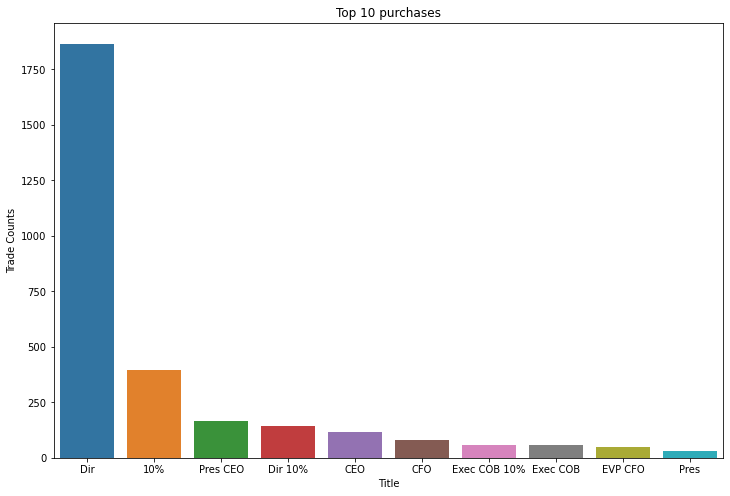

In [14]:
# Plot top 10 frequent buyers
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Title", y="Trade Counts", data=insider_purchase.sort_values(by="Trade Counts", ascending=False).head(10))
plt.title("Top 10 purchases")

Text(0.5, 1.0, 'Top 10 sell-offs')

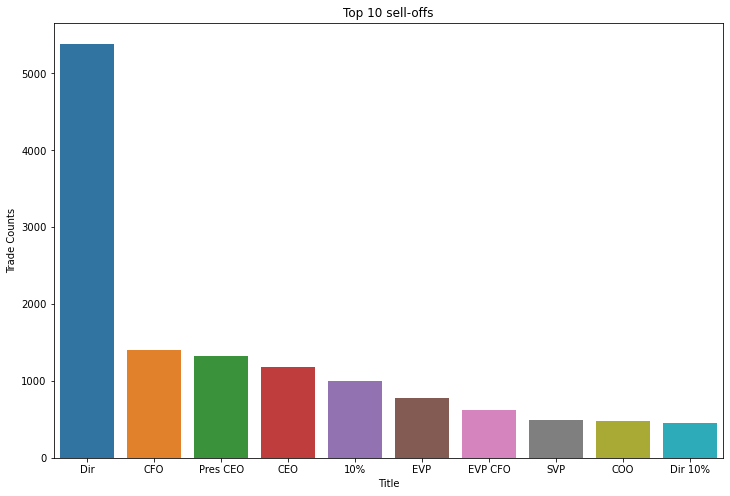

In [15]:
# Sales including "sale" and "sale+OE", grouping together
insider_sale = insider_sale.groupby("Title", as_index=False).sum("Trade Counts")

# Plot top 10 sellers
plt.figure(figsize=(12,8))
ax = sns.barplot(x="Title", y="Trade Counts", data=insider_sale.sort_values(by="Trade Counts", ascending=False).head(10))
plt.title("Top 10 sell-offs")

In [16]:
# Determine insider counts

insider_counts = insider_df.groupby(["Insider Name", "Title", "Company","Transaction Type"], as_index=False)["Price"].count()
insider_counts = insider_counts.rename(columns={"Price" : "Count"})
insider_counts = insider_counts.sort_values(by="Count", ascending=False)


In [17]:
insider_counts.head(10)

,Insider Name,Title,Company,Transaction Type,Count
5162,Istar Inc.,10%,Safehold Inc.,P - Purchase,90
814,Benioff Marc,COB co-CEO,Salesforce Inc.,S - Sale+OE,72
6444,Lilly Endowment Inc,10%,Eli Lilly & Co,S - Sale,68
3811,Garcia Ernest C. II,10%,Carvana Co.,S - Sale+OE,54
10600,Steinert Langley,Exec COB 10%,Cargurus Inc.,S - Sale,52
459,Ault Milton C III,Exec COB 10%,Ault Global Holdings Inc.,P - Purchase,51
2129,Clemons V Gordon,COB,Corvel Corp,S - Sale,50
8215,Oringer Jonathan,Exec COB 10%,Shutterstock Inc.,S - Sale,49
9827,Schwab Charles R.,COB,Schwab Charles Corp,S - Sale,48
721,Bcp Gp Ltd,Dir 10%,Graftech International Ltd,S - Sale,47


In [18]:
# Which companies have the most sells and which companies have the most purchases by insiders (by transaction counts)?
comp_buy = insider_counts[insider_counts["Transaction Type"]=="P - Purchase"].groupby("Company", as_index=False)["Count"].sum()
comp_buy.head(10)

,Company,Count
0,0 Relic Inc.,1
1,0 Residential Investment Corp.,2
2,0ell Brands Inc.,4
3,0link Genetics Corp,9
4,0mark Group Inc.,5
5,0s Corp,2
6,2U Inc.,4
7,3D Systems Corp,5
8,8X8 Inc /de/,1
9,Aar Corp,1


[Text(0, 0, 'Consolidated Edison Inc'),
 Text(1, 0, 'Safehold Inc.'),
 Text(2, 0, 'Ault Global Holdings Inc.'),
 Text(3, 0, 'Simon Property Group Inc /de/'),
 Text(4, 0, 'Community Bancorp /vt'),
 Text(5, 0, 'Rgc Resources Inc'),
 Text(6, 0, 'Net 1 Ueps Technologies Inc'),
 Text(7, 0, 'Great American Group Inc.'),
 Text(8, 0, 'Global Water Resources Inc.'),
 Text(9, 0, 'Crawford & Co')]

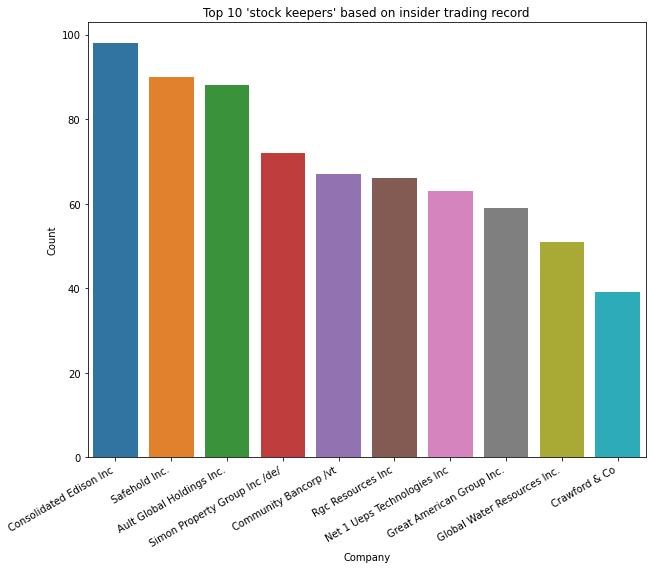

In [19]:
# Companies that have been bought the most
plt.figure(figsize=(10,8))
ax = sns.barplot(x="Company", y="Count", data=comp_buy.sort_values(by="Count",ascending=False).head(10))
plt.title("Top 10 'stock keepers' based on insider trading record")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

In [20]:
# Companies that have been sold the most
comp_sale = insider_counts[(insider_counts["Transaction Type"]=="S - Sale")|(insider_counts["Transaction Type"]=="S - Sale+OE")]
comp_sale.head(10)

,Insider Name,Title,Company,Transaction Type,Count
814,Benioff Marc,COB co-CEO,Salesforce Inc.,S - Sale+OE,72
6444,Lilly Endowment Inc,10%,Eli Lilly & Co,S - Sale,68
3811,Garcia Ernest C. II,10%,Carvana Co.,S - Sale+OE,54
10600,Steinert Langley,Exec COB 10%,Cargurus Inc.,S - Sale,52
2129,Clemons V Gordon,COB,Corvel Corp,S - Sale,50
8215,Oringer Jonathan,Exec COB 10%,Shutterstock Inc.,S - Sale,49
9827,Schwab Charles R.,COB,Schwab Charles Corp,S - Sale,48
721,Bcp Gp Ltd,Dir 10%,Graftech International Ltd,S - Sale,47
271,Amin Tarang,CEO,E.L.F. Beauty Inc.,S - Sale,44
5607,Kellogg W K Foundation Trust,10%,Kellogg Co,S - Sale,42


In [21]:
comp_sale = comp_sale.groupby("Company", as_index=False)["Count"].sum()
comp_sale.head()

,Company,Count
0,0 Relic Inc.,68
1,0ell Brands Inc.,2
2,0link Genetics Corp,5
3,0mark Group Inc.,1
4,0mont Corp /de/,100


[Text(0, 0, 'Zynga Inc'),
 Text(1, 0, 'Teladoc Health Inc.'),
 Text(2, 0, 'Electronic Arts Inc.'),
 Text(3, 0, 'Sprout Social Inc.'),
 Text(4, 0, 'Equinix Inc'),
 Text(5, 0, 'Etsy Inc'),
 Text(6, 0, 'Snap Inc'),
 Text(7, 0, 'F5 Inc.'),
 Text(8, 0, 'Globe Life Inc.'),
 Text(9, 0, 'Goosehead Insurance Inc.')]

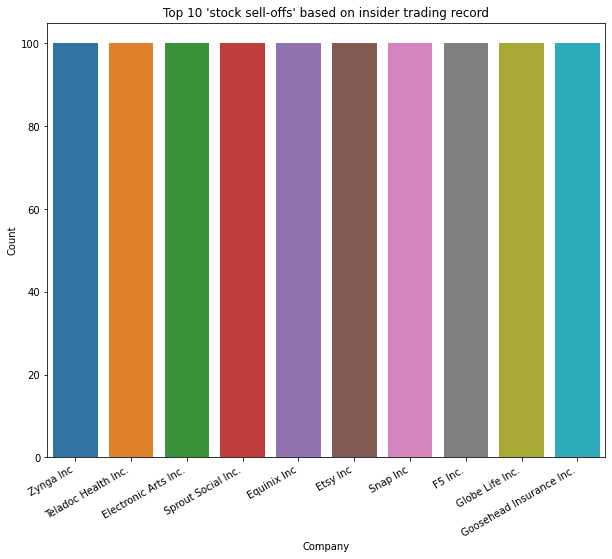

In [22]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x="Company", y="Count", data=comp_sale.sort_values(by="Count",ascending=False).head(10))
plt.title("Top 10 'stock sell-offs' based on insider trading record")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

In [23]:
# Insider counts for each company
count_df = insider_counts.drop_duplicates(subset=["Company", "Insider Name"])
count_df = count_df.groupby("Company", as_index=False)["Insider Name"].count()
count_df.head()

,Company,Insider Name
0,0 Relic Inc.,7
1,0 Residential Investment Corp.,2
2,0ell Brands Inc.,3
3,0link Genetics Corp,5
4,0mark Group Inc.,2


In [24]:
count_df = count_df.rename(columns={"Insider Name":"Number of insiders"})
count_df.head()

,Company,Number of insiders
0,0 Relic Inc.,7
1,0 Residential Investment Corp.,2
2,0ell Brands Inc.,3
3,0link Genetics Corp,5
4,0mark Group Inc.,2


In [25]:
purchase_df = pd.merge(count_df, comp_buy, on="Company", how="inner")
# Add in a column for purchase per insider
purchase_df["Purchase per insider"] = comp_buy["Count"]/count_df["Number of insiders"]
purchase_df=purchase_df.sort_values(by="Purchase per insider", ascending=False)
purchase_df.head(10)

,Company,Number of insiders,Count,Purchase per insider
507,Pb Bankshares Inc.,7,26,26.000000
313,Global Water Resources Inc.,5,51,25.500000
590,Six Flags Entertainment Corp,9,21,21.000000
67,Appian Corp,13,20,20.000000
444,Mge Energy Inc,6,17,17.000000
492,Old Republic International Corp,13,31,15.500000
156,Capitala Finance Corp.,2,14,14.000000
193,Community Bancorp /vt,13,67,13.400000
562,Safehold Inc.,2,90,12.857143
259,Energy Transfer LP,8,20,10.000000


In [26]:
sales_df = pd.merge(comp_sale, count_df, on="Company", how="inner")
sales_df["sale per insider"] = comp_sale["Count"]/count_df["Number of insiders"]
sales_df = sales_df.sort_values(by="sale per insider", ascending=False)


In [27]:
sales_df.head(10)

,Company,Count,Number of insiders,sale per insider
801,Pinterest Inc.,99,9,99.0
67,Alphabet Inc.,99,12,99.0
203,Boston Scientific Corp,91,19,91.0
438,First Solar Inc.,83,16,83.0
215,Broadcom Inc.,60,12,60.0
551,Insperity Inc.,60,9,60.0
1106,Zebra Technologies Corp,55,14,55.0
998,Travelers Companies Inc.,52,12,52.0
919,Snap Inc,100,9,50.0
4,0mont Corp /de/,100,10,50.0


In [28]:
# Impact insider tradings have on stock prices on trading days and file days
file = (insider_df["Date Filed Close"] - insider_df["Date Filed Open"])/insider_df["Date Filed Open"]
trade = (insider_df["Date Traded Close"] - insider_df["Date Traded Open"])/insider_df["Date Traded Open"]

# insider_impact = insider_df[["Diff on File", "Diff on Trading"]] = [file, trade] 

# insider_impact = insider_df.join(pd.DataFrame({"Diff on File": (insider_df["Date Filed Close"] - insider_df["Date Filed Open"])/insider_df["Date Filed Open"], 
#                                                "Diff on Trading" : (insider_df["Date Traded Close"] - insider_df["Date Traded Open"])/insider_df["Date Traded Open"]}))
# insider_impact.head()


In [29]:
insider_df["Diff on File"] =file
insider_df["Diff on Trading"] = trade

In [30]:
insider_df.head()

,Company,Filing Date,Trade Date,Insider Name,Title,Transaction Type,Price,Quantity,Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close,Change of Amount Owned,Diff on File,Diff on Trading
0,0 Relic Inc.,03/09/2020 17:31,01/09/2020,Cirne Lewis,CEO 10%,S - Sale,62.74,-35500,6202967,-2227184,61.730000,60.320000,61.529999,62.799999,-0.005691,-0.022841,0.020640
1,0 Relic Inc.,02/10/2020 17:52,01/10/2020,Cirne Lewis,CEO 10%,S - Sale,57.48,-34500,6168467,-1982897,56.029999,56.310001,57.150002,57.349998,-0.005562,0.004997,0.003499
2,0 Relic Inc.,04/11/2020 17:03,02/11/2020,Cirne Lewis,CEO 10%,S - Sale,58.92,-35500,6132976,-2091741,63.330002,63.150002,60.959999,58.919998,-0.005755,-0.002842,-0.033465
3,0 Relic Inc.,10/11/2020 19:13,10/11/2020,Henshall David J,Dir,P - Purchase,54.74,4750,4750,260009,55.450001,53.730000,55.450001,53.730000,NaN,-0.031019,-0.031019
4,0 Relic Inc.,17/11/2020 18:13,16/11/2020,Sachleben Mark,CFO,S - Sale+OE,56.00,-2351,371740,-131661,55.150002,56.450001,56.029999,54.790001,-0.006285,0.023572,-0.022131


In [31]:
# Total trading volume per day for each company
trading_df = insider_df.groupby(["Company", "Trade Date"], as_index=False).aggregate({"Quantity": "sum", "Change of Amount Owned": "mean", "Diff on File": "max", "Diff on Trading": "max"})
trading_df.sort_values(by="Change of Amount Owned", ascending = False, inplace=True)
trading_df.head(10)

,Company,Trade Date,Quantity,Change of Amount Owned,Diff on File,Diff on Trading
821,Advantage Solutions Inc.,19/03/2021,91713,908.333333,0.007739,-0.004608
12186,Hepion Pharmaceuticals Inc.,02/12/2020,7000,875.000000,-0.053571,-0.053571
21838,Sonos Inc,19/02/2021,53666,496.907407,0.037442,0.007932
13125,Interlink Plus Inc.,30/09/2020,7953108,363.892928,0.000000,NaN
12185,Hepion Pharmaceuticals Inc.,01/12/2020,12000,203.389831,-0.029412,-0.029412
23806,Tripadvisor Inc.,29/03/2021,1713859,126.161009,-0.012484,-0.035009
18202,Pb Bankshares Inc.,16/08/2021,25025,125.125000,0.011450,0.019380
1372,Alliant Energy Corp,09/06/2022,1200,120.000000,-0.021821,-0.022299
12187,Hepion Pharmaceuticals Inc.,08/12/2020,25000,96.525097,0.107595,0.107595
6203,Chipotle Mexican Grill Inc,23/04/2021,673,48.071429,-0.007024,-0.009089


In [32]:
# For Change of Amount Owned equals to 0 and "inf", we will drop and not be considered
insider2_df = insider_df.dropna(subset=["Change of Amount Owned"], axis=0)
insider2_df.sort_values("Change of Amount Owned", inplace=True)
insider2_df.head(10)

<ipython-input-32-c84643279ba2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insider2_df.sort_values("Change of Amount Owned", inplace=True)


,Company,Filing Date,Trade Date,Insider Name,Title,Transaction Type,Price,Quantity,Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close,Change of Amount Owned,Diff on File,Diff on Trading
10156,Community Bancorp /vt,08/04/2021 08:13,06/04/2021,Oeschger Fredric,Dir,P - Purchase,19.50,120056,115751,2341088,20.000000,20.000000,19.500000,19.500000,-27.887573,0.000000,0.000000
11005,Counsel Rb Capital Inc.,25/08/2021 20:15,25/08/2021,Hexner Michael,Dir,P - Purchase,1.90,34504,26992,65515,1.850000,2.050000,1.850000,2.050000,-4.593184,0.108108,0.108108
1740,Aimmune Therapeutics Inc.,15/10/2020 19:18,13/10/2020,Societe Des Produits Nestle S.A.,10%,P - Purchase,34.50,54117287,36661564,1867046402,0.000000,0.000000,30.170000,29.820000,-3.100260,NaN,-0.011601
5100,Aware Inc /ma/,20/11/2020 16:46,18/11/2020,Barcelo David Brian,CFO,P - Purchase,2.74,15000,10000,41150,2.700000,2.690000,2.790000,2.730000,-3.000000,-0.003704,-0.021505
3878,Appfolio Inc,22/10/2021 20:05,20/10/2021,Rauth William R III,Dir 10%,P - Purchase,130.87,72859,47770,9535057,133.580002,132.960007,131.869995,131.130005,-2.904022,-0.004641,-0.005612
28701,Rgc Resources Inc,03/11/2020 15:05,02/11/2020,Agee Nancy H,Dir,P - Purchase,23.88,62814,38278,1499998,24.100000,24.629999,23.980000,23.879999,-2.560075,0.021992,-0.004170
23432,Moneygram International Inc,29/10/2020 19:37,10/06/2020,Gsmp V Onshore Us Ltd.,10%,P - Purchase,3.25,74338,38202,241937,4.450000,4.490000,3.800000,3.340000,-2.057173,0.008989,-0.121053
23434,Moneygram International Inc,29/10/2020 19:42,10/06/2020,Goldman Sachs & Co. LLC,10%,P - Purchase,3.25,74338,38202,241937,4.450000,4.490000,3.800000,3.340000,-2.057173,0.008989,-0.121053
7436,Bridgebio Pharma Inc.,30/12/2021 20:17,28/12/2021,Daniels Ronald J,Dir,P - Purchase,13.49,22147,10402,298679,14.000000,14.550000,12.180000,13.430000,-1.885653,0.039286,0.102627
29751,Sentinelone Inc.,06/07/2021 21:14,02/07/2021,Insight Holdings Group LLC,10%,P - Purchase,35.00,202556,7190,7089460,45.810001,49.500000,42.110001,44.590000,-1.036803,0.080550,0.058893


In [33]:
#Top 10 sellers
insider_topseller = insider2_df[0:10][["Company", "Diff on File", "Diff on Trading"]]
topseller_unpivot = pd.melt(insider_topseller, id_vars="Company", value_vars=["Diff on File", "Diff on Trading"])
topseller_unpivot

,Company,variable,value
0,Community Bancorp /vt,Diff on File,0.000000
1,Counsel Rb Capital Inc.,Diff on File,0.108108
2,Aimmune Therapeutics Inc.,Diff on File,NaN
3,Aware Inc /ma/,Diff on File,-0.003704
4,Appfolio Inc,Diff on File,-0.004641
5,Rgc Resources Inc,Diff on File,0.021992
6,Moneygram International Inc,Diff on File,0.008989
7,Moneygram International Inc,Diff on File,0.008989
8,Bridgebio Pharma Inc.,Diff on File,0.039286
9,Sentinelone Inc.,Diff on File,0.080550


[Text(0, 0, 'Community Bancorp /vt'),
 Text(1, 0, 'Counsel Rb Capital Inc.'),
 Text(2, 0, 'Aimmune Therapeutics Inc.'),
 Text(3, 0, 'Aware Inc /ma/'),
 Text(4, 0, 'Appfolio Inc'),
 Text(5, 0, 'Rgc Resources Inc'),
 Text(6, 0, 'Moneygram International Inc'),
 Text(7, 0, 'Bridgebio Pharma Inc.'),
 Text(8, 0, 'Sentinelone Inc.')]

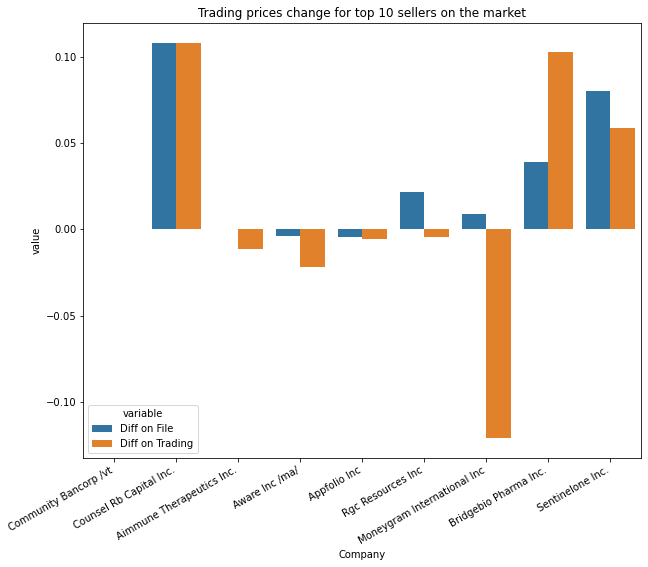

In [34]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=topseller_unpivot, x="Company", y="value", hue="variable")
plt.title("Trading prices change for top 10 sellers on the market")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

In [35]:
#Top 10 buyers
insider_topbuyer = insider2_df[-10:][["Company", "Diff on File", "Diff on Trading"]]
topbuyer_unpivot = pd.melt(insider_topbuyer, id_vars="Company", value_vars=["Diff on File", "Diff on Trading"])
topbuyer_unpivot

,Company,variable,value
0,Alliant Energy Corp,Diff on File,-0.021821
1,Interlink Plus Inc.,Diff on File,0.000000
2,Tripadvisor Inc.,Diff on File,-0.026303
3,Pb Bankshares Inc.,Diff on File,0.011450
4,Hepion Pharmaceuticals Inc.,Diff on File,-0.029412
5,Tripadvisor Inc.,Diff on File,-0.012484
6,Sonos Inc,Diff on File,0.037442
7,Interlink Plus Inc.,Diff on File,0.000000
8,Hepion Pharmaceuticals Inc.,Diff on File,-0.053571
9,Advantage Solutions Inc.,Diff on File,0.003663


[Text(0, 0, 'Alliant Energy Corp'),
 Text(1, 0, 'Interlink Plus Inc.'),
 Text(2, 0, 'Tripadvisor Inc.'),
 Text(3, 0, 'Pb Bankshares Inc.'),
 Text(4, 0, 'Hepion Pharmaceuticals Inc.'),
 Text(5, 0, 'Sonos Inc'),
 Text(6, 0, 'Advantage Solutions Inc.')]

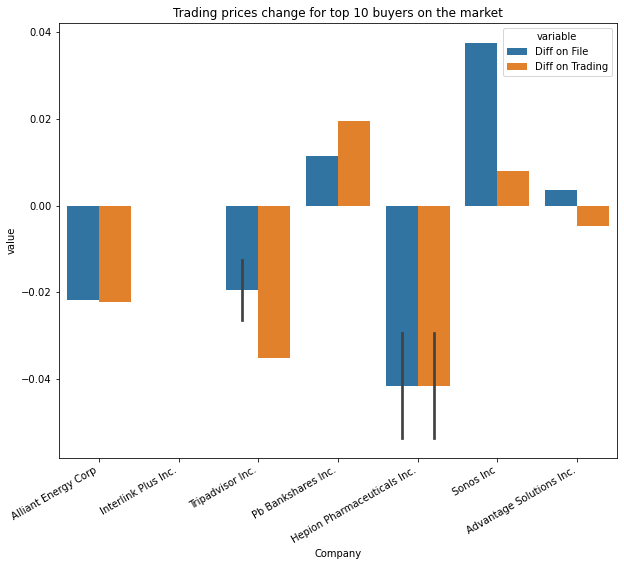

In [38]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=topbuyer_unpivot, x="Company", y="value", hue="variable")
plt.title("Trading prices change for top 10 buyers on the market")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment="right")

From the above analysis, we can draw the conclusion that the stock prices are barely affected by insider trading for the most traded companies.

In [39]:
trading_df.head()

,Company,Trade Date,Quantity,Change of Amount Owned,Diff on File,Diff on Trading
821,Advantage Solutions Inc.,19/03/2021,91713,908.333333,0.007739,-0.004608
12186,Hepion Pharmaceuticals Inc.,02/12/2020,7000,875.000000,-0.053571,-0.053571
21838,Sonos Inc,19/02/2021,53666,496.907407,0.037442,0.007932
13125,Interlink Plus Inc.,30/09/2020,7953108,363.892928,0.000000,NaN
12185,Hepion Pharmaceuticals Inc.,01/12/2020,12000,203.389831,-0.029412,-0.029412


In [40]:
# Explore the degree of the impact from the insider trading on the biggest prices change on trading days
diff_trading = trading_df.sort_values(by="Diff on Trading", ascending=False)[0:10]

In [41]:
diff_trading

,Company,Trade Date,Quantity,Change of Amount Owned,Diff on File,Diff on Trading
25068,Vir Biotechnology Inc.,26/01/2021,-31300,-0.485271,0.155901,0.719555
18419,Petmed Express Inc,02/06/2021,-6000,-0.164271,-0.010889,0.576318
10960,Gamestop Corp.,13/01/2021,-89619,-0.326625,-0.077683,0.537708
16283,Monmouth Real Estate Investment Corp,15/12/2020,224,0.003181,NaN,0.509091
4137,Biogen Inc.,04/11/2020,-1500,-0.102980,0.000000,0.404542
9969,Everspin Technologies Inc,12/11/2021,-1021950,-0.223121,0.028007,0.349246
11411,Gogo Inc.,02/09/2020,-18371,-0.290593,0.064687,0.348506
4138,Biogen Inc.,07/06/2021,-10759,-0.472003,0.030228,0.340274
2505,Appian Corp,10/05/2022,633918,-0.540998,0.085768,0.316696
3866,Bed Bath & Beyond Inc,16/08/2022,-5055013,-0.409950,-0.026758,0.313613


In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(y="Diff on Trading", x="Change of Amount Owned", data=diff_trading, palette="Reds")
plt.title("Top 10 increasing ")

<AxesSubplot:>

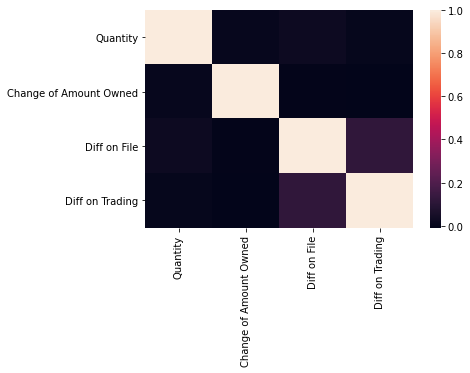

In [42]:
#Parameter correlation
sns.heatmap(trading_df.corr())

<AxesSubplot:>

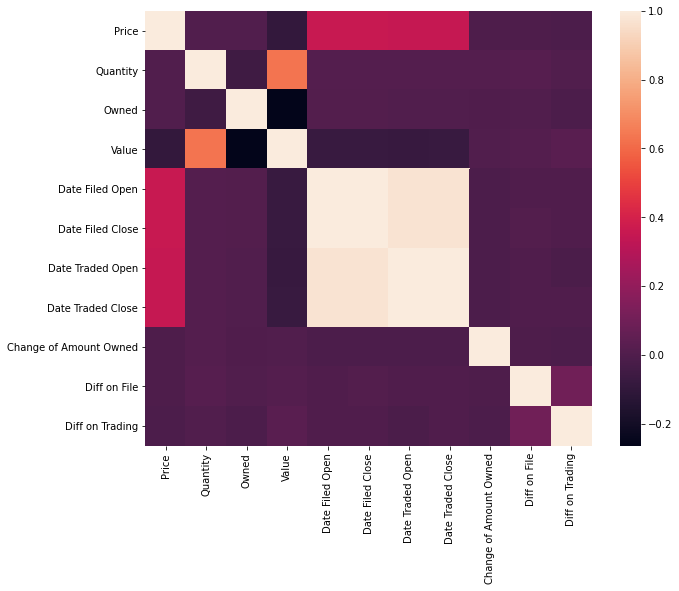

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(insider_df.corr())

From the above heatmaps, we can deduced that the parameters barely have any correlations with each other.

In [ ]:
diff_file = insider_df[["Company", "Filing Date", "Title", "Change of Amount Owned", "Transaction Type", "Diff on File"]].sort_values(by="Diff on File", ascending=False)[0:10]

In [ ]:
diff_file

# ML model

In [45]:
insider_df.head()

,Company,Filing Date,Trade Date,Insider Name,Title,Transaction Type,Price,Quantity,Owned,Value,Date Filed Open,Date Filed Close,Date Traded Open,Date Traded Close,Change of Amount Owned,Diff on File,Diff on Trading
0,0 Relic Inc.,03/09/2020 17:31,01/09/2020,Cirne Lewis,CEO 10%,S - Sale,62.74,-35500,6202967,-2227184,61.730000,60.320000,61.529999,62.799999,-0.005691,-0.022841,0.020640
1,0 Relic Inc.,02/10/2020 17:52,01/10/2020,Cirne Lewis,CEO 10%,S - Sale,57.48,-34500,6168467,-1982897,56.029999,56.310001,57.150002,57.349998,-0.005562,0.004997,0.003499
2,0 Relic Inc.,04/11/2020 17:03,02/11/2020,Cirne Lewis,CEO 10%,S - Sale,58.92,-35500,6132976,-2091741,63.330002,63.150002,60.959999,58.919998,-0.005755,-0.002842,-0.033465
3,0 Relic Inc.,10/11/2020 19:13,10/11/2020,Henshall David J,Dir,P - Purchase,54.74,4750,4750,260009,55.450001,53.730000,55.450001,53.730000,NaN,-0.031019,-0.031019
4,0 Relic Inc.,17/11/2020 18:13,16/11/2020,Sachleben Mark,CFO,S - Sale+OE,56.00,-2351,371740,-131661,55.150002,56.450001,56.029999,54.790001,-0.006285,0.023572,-0.022131


In [52]:
#Preprocessing
X = insider_df[["Price", "Quantity", "Owned", "Date Traded Open"]]
y = insider_df["Date Traded Close"]
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2)

In [58]:
# LinearRegression, train by using insider_df
LR = LinearRegression()
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.9988512016693497

In [53]:
# Random forest regression, training by using insider_df
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.9994318300013707

Overfitting was observed.

In [63]:
# KFold Cross Validation to overcome overfitting issue
kf = KFold(n_splits = 10)
# for train_index, test_index in kf.split(X):
#     print("Train" : train_index, "Test" : test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [66]:
# Fit into the model
XGB = XGBRegressor(n_estimators=100, max_depth=3)
score = cross_val_score(XGB, X, y, cv=kf)

In [67]:
print('Mean MAE: %.3f (%.3f)' % (score.mean(), score.std()) )

Mean MAE: 0.997 (0.003)


XGBRegressor fits the datasets pretty well considering the MAE.